# Peptide Chef

In [2]:
# Created by: Tyler T. Cooper, PhD (2021)
# Tools to Analyze Peptides and Amino Acid Compositions

## Libraries

In [3]:
### Data Handling
import numpy as np
import pandas as pd
from pandas import ExcelWriter
import openpyxl
import re
import pyteomics
from pyteomics import fasta, parser, electrochem, mass
from itertools import combinations
from urllib.request import urlretrieve
import gzip
#dfdfdf
#Statistics
import statsmodels.api as sm
from statsmodels.formula.api import ols

#Figure Generation
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import offsetbox
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import NullFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.tri import Triangulation
from mpl_toolkits.mplot3d import axes3d
from IPython.display import Image, display
import seaborn as sns
from adjustText import adjust_text
import glob
import bioinfokit
from bioinfokit import analys, visuz
from wordcloud import WordCloud

#Venn Diagrams
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
%matplotlib inline

cmap = 'PRGn'
fmt='eps'
dpi=600

## Import Fasta File

In [4]:
url="https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000005640/UP000005640_9606.fasta.gz"

In [5]:

# Use if Fasta file is Local
def Cook_Book(Species=None,homebrew=False, takeout=True,url=None,measure=False,target=None):
    ingredients=list()
    if takeout is True:
        homebrew=False
        print('Downloading the FASTA file from url...')
        urlretrieve(url,'temp.fasta.gz')
        print('Unzipping...')
        with gzip.open('temp.fasta.gz', mode='rt') as gzfile:
            for info, contents in fasta.FASTA(gzfile):
                taste=list((info,contents))
                ingredients.append(taste)
                recipie=pd.DataFrame(ingredients,columns=['ID','Peptide'])
        print("Takeout is Done!")
    if homebrew is True:
        print("Downloading the FASTA file from local flle...")
        book = str(Species+".fasta")
        recipie=pd.DataFrame()
        print("Serving up a homebrew...")
        with fasta.read(book) as menu:
            for info, contents in menu:
                taste=list((info,contents))
                ingredients.append(taste)
                recipie=pd.DataFrame(ingredients,columns=['ID','Peptide'])
        print("Homebrow is Done!")
    recipie[['db', 'UniprotID','ID2']] = recipie['ID'].str.split('|', 2, expand=True)
    recipie[['Gene','Identification']] = recipie['ID2'].str.split('_', 1, expand=True)
    recipie.drop(columns=['ID', 'ID2',"db"], inplace=True)
    if measure == True:
        print("Measuring...")
        recipie["Protein_Length"]=recipie[target].str.len()
    print("Here ya go boss!")
    return(recipie)

In [6]:
menu=Cook_Book(takeout=True,url=url, measure=True, target="Peptide")

Unzipping...
Takeout is Done!
Measuring...
Here ya go boss!


In [7]:
menu.head()

,Peptide,UniprotID,Gene,Identification,Protein_Length
0,MKHLWFFLLLVAAPRWVLSQVQLQESGPGLVKPSGTLSLTCAVSGG...,A0A075B6R2,HV404,HUMAN Immunoglobulin heavy variable 4-4 OS=Hom...,117
1,XNSGGSNYKLTFGKGTLLTVNP,A0A075B6W9,A0A075B6W9,HUMAN T cell receptor alpha joining 53 (Fragme...,22
2,XNSGGYQKVTFGTGTKLQVIP,A0A075B709,A0A075B709,HUMAN T cell receptor alpha joining 13 (Fragme...,21
3,MASNVTNKMDPHSVNSRVFIGNLNTLVVKKSDVEAIFSKYGKIAGC...,A0A0G2JNQ3,A0A0G2JNQ3,HUMAN Heterogeneous nuclear ribonucleoprotein ...,293
4,SNQPQHFGDGTRLSIL,A0A0J9YXM7,TJB15,HUMAN T cell receptor beta joining 1-5 OS=Homo...,16


## Defined Variables, Compiliers, Accessory Functions

### Accessory Functions 

In [8]:
def PEAKS_Importer(csv,drop_OG=True):
    df=pd.read_csv(csv)
    df[["Protein","Y"]]=df['Protein Accession'].str.split("|",1,expand=True)
    df[["Gene","Species"]]=df['Y'].str.split("_",1,expand=True)
    if drop_OG==True:
        df.drop(columns=['Y', 'Protein Accession',"Found By"], inplace=True)
    else:
        df.drop(columns=['Y',"Found By"], inplace=True)
    return(df)

In [9]:
def Excel_Mapper(list_dfs, xls_path):
    with ExcelWriter(xls_path) as writer:
        for n, df in enumerate(list_dfs):
            df.to_excel(writer,'sheet%s' % n)
        writer.save()

In [10]:
def MeatWrapper(workbook,old,new,output):
    meat = openpyxl.load_workbook(workbook)
    wrap = meat[old]
    wrap.title = new
    meat.save(output)

In [11]:
def Sampler(df,toothpicks,samples):
    platter = {}
    for toothpick, sample in zip(toothpicks, samples):
        platter[sample] = df[toothpick]
    return platter

## Primary Functions

In [12]:
def Peptide_Mass(peptide):
    mass = {  "A": 71.037114,
    "R": 156.101111,
    "N": 114.042927,
    "D": 115.026943,
    "C": 103.009185,
    "Q": 129.042593,
    "E": 128.058578,
    "G": 57.021464,
    "H": 137.058912,
    "I": 113.084064,
    "L": 113.084064,
    "K": 128.094963,
    "M": 131.040485,
    "F": 147.068414,
    "P": 97.052764,
    "S": 87.032028,
    "T": 101.047679,
    "W": 186.079313,
    "Y": 163.06332,
    "V": 99.068414,
    }
    mass_list = [mass.get(aa,0.0)for aa in peptide]
    pep_mass=sum(mass_list)
    return pep_mass 

In [13]:
def ButcherShop(df,target,identifier, rule, min_length=7,exception=None,max_length=100, pH=2.0, min_charge=2,missed=0):
    raw=df[[target, identifier]].set_index(identifier).to_dict()[target]
    string_catcher=re.compile(r'^([A-Z]+)$')
    pep_dict = {}
    pep_dict_list = []
    print(f'You order is being processed and the butcher is preparing your {rule}-cut protein(s)!')
    print("The butcher is working...")
    for gene,peptide in raw.items():
        pep_dict[gene] = list(parser.cleave(peptide,rule=rule,min_length=min_length,exception=exception,missed_cleavages=missed))
    for k, lst in pep_dict.items():    
        d = {}
        for i in range(len(lst)):
            d.update({k: lst[i]})
            d.update({'gene':k})
            d.update({'aa_comp': dict(parser.amino_acid_composition(lst[i]))})
            d.update({'peptide': re.findall(string_catcher,lst[i])})
            d.update({'Length': len(lst[i])})
            d.update({'z': int(round(electrochem.charge(lst[i], pH=pH)))})
            d.update({'Mass': int(Peptide_Mass(lst[i]))})
            if d["z"] > 0:
                d.update({'m/z': d["Mass"]/d['z']})
            new_d = d.copy()
            pep_dict_list.append(new_d)
    print("Trimming the cuts....")
    pep_dict_list = [peptide for peptide in pep_dict_list if peptide['Length'] <= int(max_length)]
    print("Weighing the cuts...")
    pep_dict_list = [peptide for peptide in pep_dict_list if peptide['z'] >= int(min_charge)]
    print(f'Order is up! You have acquired {len(pep_dict_list)} peptides that are between {min_length} and {max_length} amino acids!')
    return pep_dict_list
        

In [83]:
meat=ButcherShop(menu,"Peptide","Gene","thermolysin")
cuts=DeliShop(meat,meat_package=True)
cuts

You order is being processed and the butcher is preparing your thermolysin-cut protein(s)!
The butcher is working...
Trimming the cuts....
Weighing the cuts...
Order is up! You have acquired 339178 peptides that are between 7 and 100 amino acids!


,gene,aa_comp,peptide,Length,z,Mass,m/z,counts
0,HV404,"{'V': 1, 'D': 1, 'K': 2, 'S': 1, 'N': 1, 'Q': 1}",VDKSKNQ,7,3,800,266.666667,3
1,HV404,"{'V': 1, 'R': 1, 'Q': 1, 'P': 2, 'G': 2, 'K': 1}",VRQPPGKG,8,3,820,273.333333,3
2,HV404,"{'I': 2, 'G': 2, 'E': 1, 'Y': 2, 'H': 1, 'S': ...",IGEIYHSGSTNYNPS,15,2,1618,809.000000,3
3,A0A075B6W9,"{'X': 1, 'N': 2, 'S': 2, 'G': 2, 'Y': 1, 'K': 1}",XNSGGSNYK,9,2,807,403.500000,1
4,A0A075B709,"{'X': 1, 'N': 1, 'S': 1, 'G': 2, 'Y': 1, 'Q': ...",XNSGGYQK,8,2,735,367.500000,1
...,...,...,...,...,...,...,...,...
339173,PKHA5,"{'A': 1, 'P': 1, 'T': 2, 'K': 1, 'E': 1, 'N': 2}",APTKETNN,8,2,854,427.000000,49
339174,PKHA5,"{'I': 1, 'S': 3, 'Y': 1, 'E': 2, 'T': 2, 'P': ...",ISYESTPEVSRGNQT,15,2,1647,823.500000,49
339175,PKHA5,"{'M': 1, 'D': 2, 'K': 3, 'E': 1, 'R': 1, 'N': 1}",MDKERNKDK,9,5,1143,228.600000,49
339176,PKHA5,"{'I': 1, 'P': 2, 'T': 1, 'S': 3, 'H': 1, 'G': 1}",IPTSPSHGS,9,2,863,431.500000,49


In [84]:
def LabelMaker(df,df2,Key=None,Merge=None,Label=None):
    labeler=df.set_index(Key).to_dict()[Label]
    df2[Label] = df2[Merge].map(labeler)
    return df2

In [85]:
fresh=LabelMaker(menu,cuts,Key="Gene",Merge="gene",Label="Protein_Length")
fresh["% of Protein"]= (fresh["Length"]/fresh["Protein_Length"])*100
fresh

,gene,aa_comp,peptide,Length,z,Mass,m/z,counts,Protein_Length,% of Protein
0,HV404,"{'V': 1, 'D': 1, 'K': 2, 'S': 1, 'N': 1, 'Q': 1}",VDKSKNQ,7,3,800,266.666667,3,117,5.982906
1,HV404,"{'V': 1, 'R': 1, 'Q': 1, 'P': 2, 'G': 2, 'K': 1}",VRQPPGKG,8,3,820,273.333333,3,117,6.837607
2,HV404,"{'I': 2, 'G': 2, 'E': 1, 'Y': 2, 'H': 1, 'S': ...",IGEIYHSGSTNYNPS,15,2,1618,809.000000,3,117,12.820513
3,A0A075B6W9,"{'X': 1, 'N': 2, 'S': 2, 'G': 2, 'Y': 1, 'K': 1}",XNSGGSNYK,9,2,807,403.500000,1,22,40.909091
4,A0A075B709,"{'X': 1, 'N': 1, 'S': 1, 'G': 2, 'Y': 1, 'Q': ...",XNSGGYQK,8,2,735,367.500000,1,21,38.095238
...,...,...,...,...,...,...,...,...,...,...
339173,PKHA5,"{'A': 1, 'P': 1, 'T': 2, 'K': 1, 'E': 1, 'N': 2}",APTKETNN,8,2,854,427.000000,49,1116,0.716846
339174,PKHA5,"{'I': 1, 'S': 3, 'Y': 1, 'E': 2, 'T': 2, 'P': ...",ISYESTPEVSRGNQT,15,2,1647,823.500000,49,1116,1.344086
339175,PKHA5,"{'M': 1, 'D': 2, 'K': 3, 'E': 1, 'R': 1, 'N': 1}",MDKERNKDK,9,5,1143,228.600000,49,1116,0.806452
339176,PKHA5,"{'I': 1, 'P': 2, 'T': 1, 'S': 3, 'H': 1, 'G': 1}",IPTSPSHGS,9,2,863,431.500000,49,1116,0.806452


In [121]:
def Peptide_ICE(x):
    word_could_dict = fresh["aa_comp"][x]
    wordcloud = WordCloud(width = 1500, height = 500,prefer_horizontal=1,relative_scaling=1,
                      background_color='white',contour_width=10,contour_color="black" ).generate_from_frequencies(word_could_dict)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)

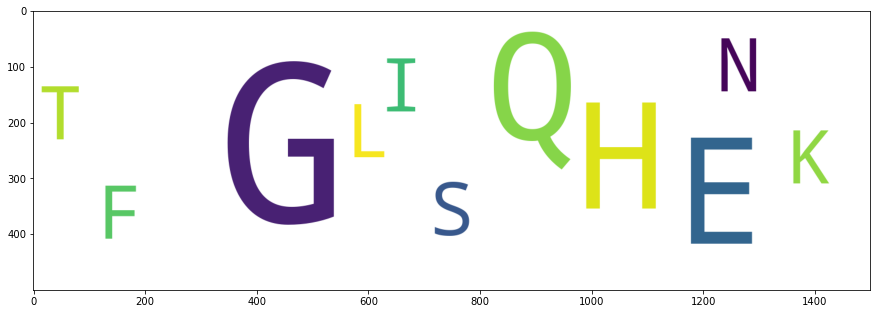

In [122]:
Peptide_ICE(420)

In [ ]:
#Handles Up to 3 Replicates (t_id1-3) per Selection, used for removing amino acids from N-terminal during PEAKS exports with enzyme that cleave at C-terminal. 
# Can be used to remove M from N-terminal of peptides produced by enzymes which cleave at N-terminal of target aa. 
def Butcher(df,ident1=None,ident2=None,ident3=None,t_id1=None,t_id2=None,t_id3=None,t_value=0,acid=["J","Z"],labels=list(),excel_mapper=True,excel_name=None):
    raw=df.loc[:,df.columns.str.contains(ident1)]
    tag=df[labels]
    raw = pd.concat([raw, tag], axis=1)
    raw["Peptide"]= raw["Peptide"].str.replace('\W+',"")
    raw["Peptide"]= raw["Peptide"].str.replace('\d+',"")
    raw["Peptide"]= raw["Peptide"].apply(lambda x : x[1:] if x.startswith(tuple(acid)) else x)
    cuts=raw.loc[:,raw.columns.str.contains(ident2)]
    if ident3 != None:
        cuts=cuts.loc[:,cuts.columns.str.contains(ident3)]
    cuts = pd.concat([cut, tag], axis=1)
    blade = cuts.filter(regex=r'^AREA').isin(['0']).all(axis=1)
    cuts=cuts.loc[~blade]
    cuts.reset_index(inplace=True)
    excels=[raw,cuts]
    Excel_Mapper(excels,excel_name +".xlsx")
    return raw, cuts

In [ ]:
z=ButcherShop(menu,"Peptide","Gene","glutamyl endopeptidase",missed=0,max_length=100)

In [ ]:
zz=ButcherShop(menu,"Peptide","Gene","glutamyl endopeptidase",missed=1,max_length=100)

In [ ]:
zzz=ButcherShop(menu,"Peptide","Gene","glutamyl endopeptidase",missed=2,max_length=100)

In [ ]:
###modify list of dictionaries based on value of key in dictionaries
# expectedResult = [d for d in z if d['Length'] > 0]
# expectedResult

In [82]:
def DeliShop(z,meat_package=False):
    #z = list of dictionaries, keys must be equal thus will drop keys which are not cosistent between dictionaries
    # use after ButcherShop
    #returns dataframe
    key_intersect = set(z[0].keys()).intersection(set(z[1].keys()))
    zz = [{key:value for (key,value) in dicts.items() if key in key_intersect} for dicts in z]
    ham = pd.DataFrame(zz)
    if meat_package == True:
        ham_counts=ham.groupby('gene').size().reset_index(name='counts')
        ham=ham.merge(ham_counts,how='left', on=['gene'])
    ham.drop(ham.columns[0],axis=1,inplace=True)
    columns=ham.columns.tolist()
    r = re.compile("^[pP]")
    P = list(filter(r.match, columns)) 
    peptide =str(P[0])
    ham[peptide]=ham[peptide].apply(",".join) # convert list within df to string
    return ham

In [89]:
test=fresh['aa_comp'].apply(pd.Series)
fresh.concat(test, axis=1)
fresh

AttributeError: 'DataFrame' object has no attribute 'concat'

In [87]:
x=fresh.loc[fresh['gene'] == "MANS4"]
y=x['aa_comp'].apply(pd.Series)
y

,L,N,T,R,S,W,D,K,G,Y,H,P,E,A,Q,C,I,V,F
21,1.0,2.0,1.0,3.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,1.0,3.0,2.0,1.0,2.0,NaN,NaN,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,2.0,NaN,3.0,NaN,3.0,NaN,1.0,NaN,NaN,NaN,1.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
24,NaN,NaN,NaN,1.0,3.0,NaN,NaN,3.0,5.0,1.0,NaN,1.0,NaN,1.0,4.0,2.0,NaN,NaN,NaN
25,NaN,2.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN
26,1.0,NaN,3.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
27,1.0,2.0,4.0,NaN,3.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0
28,1.0,NaN,1.0,1.0,4.0,NaN,NaN,2.0,1.0,2.0,NaN,NaN,1.0,NaN,1.0,3.0,NaN,NaN,NaN
29,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN


In [ ]:
# test_dict = ham["aa_comp"][2]
temp=ham.loc[ham['gene'] == "HV404"]
test_dict = temp["aa_comp"][1]
x=list(test_dict.keys())
y=list(test_dict.values())
plt.plot(x,y, color='g')

In [ ]:
def Peptide_Wash(peptide,ccut=None, PEAKS=False):
    if ccut is None:
        peptide = peptide.str.replace('\W+','')
        peptide = peptide.str.replace('\d+','')
    elif ccut == "Trypsin":
        x=[ 'R', 'K']
        if PEAKS:
            peptide= peptide.apply(lambda x : x[1:] if x.startswith(tuple(x)) else x)
        peptide = peptide.str.replace('\W+','')
        peptide = peptide.str.replace('\d+','')
        return(peptide)
    elif ccut == "AspN":
        x=['A', 'R', 'N','D', 'C', 'Q','E', 'G', 'H',
             'I', 'L', 'K', 'F', 'P',
             'S', 'T', 'W','Y', 'V']
        if PEAKS:
            peptide= peptide.apply(lambda x : x[1:] if x.startswith(tuple(x)) else x)
        peptide = peptide.str.replace('\W+','')
        peptide = peptide.str.replace('\d+','')
        return(peptide)
    elif ccut == "GluC":
        x=['E']
        if PEAKS:
            peptide= peptide.apply(lambda x : x[1:] if x.startswith(tuple(x)) else x)
        peptide = peptide.str.replace('\W+','')
        peptide = peptide.str.replace('\d+','')
        return(peptide)

In [ ]:
def Peptide_IPC(peptide,start_pH=6.51,Epsilon=0.01,):
    IPC_score={'Cterm': 2.383, 'pKAsp': 3.887, 'pKGlu': 4.317, 'pKCys': 8.297, 'pKTyr': 10.071, 'pk_his': 6.018, 'Nterm': 9.564, 'pKLys': 10.517, 'pKArg': 12.503}
    pKCterm = IPC_score['Cterm']
    pKAsp = IPC_score['pKAsp']
    pKGlu = IPC_score['pKGlu']
    pKCys = IPC_score['pKCys']
    pKTyr = IPC_score['pKTyr']
    pKHis = IPC_score['pk_his']
    pKNterm = IPC_score['Nterm']
    pKLys = IPC_score['pKLys'] 
    pKArg = IPC_score['pKArg']
    pH = start_pH      
    pHprev = 0.0         
    pHnext = 14.0        
    E = Epsilon  
    temp = 0.01
    nterm=peptide[0]
    cterm=peptide[-1]
#will now cycle through all peptides until a pH within the epsilon is found       
    while 1:             
        QN1=-1.0/(1.0+pow(10,(pKCterm-pH)))                                        
        QN2=-peptide.count('D')/(1.0+pow(10,(pKAsp-pH)))           
        QN3=-peptide.count('E')/(1.0+pow(10,(pKGlu-pH)))           
        QN4=-peptide.count('C')/(1.0+pow(10,(pKCys-pH)))           
        QN5=-peptide.count('Y')/(1.0+pow(10,(pKTyr-pH)))        
        QP1=peptide.count('H')/(1.0+pow(10,(pH-pKHis)))            
        QP2=1.0/(1.0+pow(10,(pH-pKNterm)))                
        QP3=peptide.count('K')/(1.0+pow(10,(pH-pKLys)))           
        QP4=peptide.count('R')/(1.0+pow(10,(pH-pKArg)))            
        NQ=QN1+QN2+QN3+QN4+QN5+QP1+QP2+QP3+QP4
        
        if NQ<0.0:                                  
            temp = pH
            pH = pH-((pH-pHprev)/2.0)
            pHnext = temp

        else:
            temp = pH
            pH = pH + ((pHnext-pH)/2.0)
            pHprev = temp
#terminal condition, finding pI with given precision defined by Epsilon
        if (pH-pHprev<E) and (pHnext-pH<E): 
            return pH

In [ ]:
def Peptide_ICEmaker(peptide,excel_name="Test",freeze_it=0,cut_it=6):
    ice=peptide.str.slice(freeze_it,cut_it)
    ice_ice = ice.str.slice(freeze_it,cut_it)
    ice_ice.to_excel('ICE '+excel_name+".xlsx")
    return ice_ice

In [ ]:
# Peptide_ICEmaker(nuts["peptide"])

In [ ]:
def Peptide_Neutral_pH(peptide):
    z_dict = {'E': -1, 'D': -1, 'K': 1, 'R': 1} 
    charge = [z_dict.get(aa, 0.0) for aa in peptide]
    spark=sum(charge)
    return(spark)

In [ ]:
def Peptide_Gravy(peptide):
    hydro = {     "A": 1.800,
    "R": -4.500,
    "N": -3.500,
    "D": -3.500,
    "C": 2.500,
    "Q": -3.500,
    "E": -3.500,
    "G": -0.400,
    "H": -3.200,
    "I": 4.500,
    "L": 3.800,
    "K": -3.900,
    "M": 1.900,
    "F": 2.800,
    "P": -1.600,
    "S": -0.800,
    "T": -0.700,
    "W": -0.900,
    "Y": -1.300,
    "V": 4.200,
    }
    hydro_list = [hydro.get(aa,0.0)for aa in peptide]
    hydro_sum=sum(hydro_list)
    gravy=hydro_sum/len(hydro_list)
    return gravy 

In [ ]:
def Marinate (df,target,length,IPC=False,Hydro=False,GRAVY=False,NeutralZ=False):
    print("Marinating peptides...")
    if IPC is True:
        df["IPC"]=df[target].apply(Peptide_IPC)
    if GRAVY is True:
        df["Hydro_Sum"]=df[target].apply(Peptide_Gravy)
    if NeutralZ is True:
        df["Neutral_Z"]=df[target].apply(Peptide_Neutral_pH) 
    print("Peptides have been marinated!")
    return df
        

In [ ]:
ok=Marinate(ham,"peptide","length",IPC=True,GRAVY=True,NeutralZ=True)
ok

In [ ]:
def Wishbone(df,bone,split):
    x=df[bone].value_counts()
    x2=pd.DataFrame(x,columns=[bone])
    x3= x2.loc[(x2[bone])>int(split)]
    x3z=len(x3)
    x4=x3z/len(x2)*100
    print(f"The number of proteins with > {split} peptides : %.1f" % x3z)
    print(f"Ratio of Proteins with > {split} Peptides Identified: %.3f" % x4)
    return x3,x3z,x4

In [ ]:
Wishbone(ok,'gene',3)

In [ ]:
def Sweet_N_Sour(set1,set2):
    common_IDs=list(set(set1)&set(set2))
    common=len(common_IDs)
    unique=len(list(set(set1)^set(set2)))
    unique_set1=list(set(set1)-set(set2))
    unique_set2=list(set(set2)-set(set1))
    set1_count=len(unique_set1)
    set2_count=len(unique_set2)
    Ratio=(unique/(common+unique))*100
    print("The number of common peptides is: %.3f" % common)
    print("The number of unique peptides in set1 is: %.3f" % set1_count)
    print("The number of unique peptides in set1 is: %.3f" % set2_count)
    print("The Ratio of Unique to Common proteins is: %.3f" % Ratio)
    return common_IDs,unique_set1, unique_set2

In [ ]:
def CorrPie(df,apples,figsize=(16,8),cmap='Blues',title="Title",fontsize=18,pad=16,save_name="Heat_Test",dpi=600,fmt='eps'):
    og_corr=df[apples]
    plt.figure(figsize=figsize)
    mask=np.triu(np.ones_like(og_corr.corr(), dtype=np.bool))
    heatmap=heatmap = sns.heatmap(og_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap=cmap)
    heatmap.set_title(title, fontdict={'fontsize':fontsize}, pad=pad)
    plt.savefig(save_name,format=fmt,dpi=dpi,bbox_inches="tight")
    plt.show()

In [ ]:
def WeddingCake(df,x,y,z,dpi=300,s=12,alpha=0.3,edgecolor='k',color="blue",my_viewx=20,my_viewy=50,
               xlabel="Parameter xlabel",ylabel="Parameter ylabel",zlabel="Parameter zlabel",fmt='png',
               figx=10,figy=10,xmin=0,xmax=1000,ymin=0,ymax=1000,zmin=0,zmax=1000):
    fig = plt.figure(figsize=(figx,figy),dpi=dpi)
    ax = fig.gca(projection='3d')
    X = df[x]
    Y = df[y]
    Z = df[z]
    ax.scatter(X,Y,Z,color=color,s=s,alpha=alpha,edgecolor=edgecolor)
    ax.view_init(my_viewx,my_viewy)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.xaxis._axinfo["grid"].update({"linewidth":1, "color" : "grey"})
    ax.yaxis._axinfo["grid"].update({"linewidth":1, "color" : "grey"})
    ax.zaxis._axinfo["grid"]['color'] = "k"
    ax.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax.set_ylim3d(ymin,ymax)
    ax.set_xlim3d(xmin,xmax)
    ax.set_zlim3d(zmin,zmax)
    FigTitle=input('Figure Title:')
    plt.savefig(FigTitle,format=fmt,dpi=dpi,bbox_inches="tight")
    plt.show

In [ ]:
def Cake(df,x,y,dpi=600,s=25,alpha=0.25,edgecolor='k',color="blue",fmt='eps',labsize=18,
               figx=10,figy=10,xmin=0,xmax=1000,ymin=0,ymax=1000,xlabel="xlabel parameter",ylabel="ylabel parameter",
        loc=2,pad=1,borderpad=1,frameon=True, show=False):
    fig, ax = plt.subplots(1,1,figsize=(figx,figy),dpi=dpi)
    X = df[x]
    Y = df[y]
    plt.scatter(X,Y,color=color,s=s, alpha=alpha,edgecolor=edgecolor)
    plt.xlabel(xlabel, fontsize=labsize)
    plt.ylabel(ylabel, fontsize=labsize)
    corr, _ = pearsonr(X, Y)
    # loc works the same as it does with figures (though best doesn't work)
    # pad=5 will increase the size of padding between the border and text
    # borderpad=5 will increase the distance between the border and the axes
    # frameon=False will remove the box around the text
    anchored_text = AnchoredText('Pearsons correlation: r = %.3f' % corr, loc=loc,pad=pad,borderpad=borderpad,frameon=frameon)
    ax.add_artist(anchored_text)
    FigTitle=input('Figure Title:')
    plt.savefig(FigTitle,format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
def CakePop(df,x,xi,y,yi, figx=10,figy=10,dpi=600,font_scale=1.5,figstyle="white",xlabel="xlabel",ylabel="ylabel",labsize=18,
           cmapx=-0.3,cmapy=0.0,sizex=10,sizey=200,loc='upper left',pad=1,borderpad=1,frameon=True):
    sns.set(font_scale=font_scale)
    cake=sns.set_style(figstyle)
    cmap = sns.cubehelix_palette(start=cmapx, rot=cmapy, as_cmap=True)
    X = df[x]
    Y = df[y]
    cake=sns.relplot(data=df,
    x=X, y=Y,
    hue=xi, size=yi,
    palette=cmap, sizes=(sizex, sizey))
    ax = cake.axes[0,0]
    ####
    corr, _ = pearsonr(X, Y)
    anchored_text = AnchoredText('Pearsons correlation: r = %.3f' % corr, loc=loc, prop=dict(size=labsize*0.5),pad=pad,borderpad=borderpad,frameon=frameon)
    ax.add_artist(anchored_text)
    ####
    plt.xlabel(xlabel, fontsize=labsize)
    plt.ylabel(ylabel, fontsize=labsize)
    FigTitle=input('Figure Title:')
    plt.savefig(FigTitle,format=fmt,dpi=dpi,bbox_inches="tight")
    plt.show(cake)